In [47]:
import numpy as np
import matplotlib.cm as cm
from matplotlib import ticker
import math
import scipy
from scipy import spatial
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import dask
from sklearn.neighbors import KDTree
import netCDF4
from metpy import calc
from metpy.units import units
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats
import pandas as pd

import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs

from sklearn.cluster import KMeans
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import metrics
from scipy.ndimage import gaussian_filter
from sklearn.linear_model import LinearRegression

import seaborn as sns
from matplotlib.colors import ListedColormap

In [42]:
fz = 15*1.5
lw = 4
siz = 100
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YTEXT = 0.3 # Text placement

plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
#mpl.rcParams["font.serif"] = "STIX"
plt.rc('font', family='serif', size=fz)
matplotlib.rcParams['lines.linewidth'] = lw

In [43]:
path_to_file = '/DFS-L/DATA/pritchard/gmooers/Raw_Data_Storage/MAPS/SPCAM/100_Days/New_SPCAM5/archive/TimestepOutput_Neuralnet_SPCAM_216/atm/hist/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-00000.nc'
extra_variables = xr.open_dataset(path_to_file)
latitudes = np.squeeze(extra_variables.LAT_20s_to_20n.values)
longitudes = np.squeeze(extra_variables.LON_0e_to_360e.values)
new_lons, new_lats = np.meshgrid(longitudes, latitudes)

# Load in saved data

In [51]:
sc_convection_proportion = -1*np.load("/fast/gmooers/PNAS_Repo/compressed_data/SC_Map_K_3_VAE_3312.npy")
csc_convection_proportion = -1*np.load("/fast/gmooers/PNAS_Repo/compressed_data/CSC_Map_K_3_VAE_3312.npy")
deep_convection_proportion = -1*np.load("/fast/gmooers/PNAS_Repo/compressed_data/DEEP_Map_K_3_VAE_3312.npy")

P_95_0k = np.load("Compressed_Data/P_95_0k.npy")
P_95_4k = np.load("Compressed_Data/P_95_4k.npy")
mean_changes = np.load("Compressed_Data/Mean_Thermo.npy")

deep_conv_regime_shift = np.load("Compressed_Data/deep_conv_regime_shift.npy")
shallow_conv_regime_shift = np.load("Compressed_Data/shallow_conv_regime_shift.npy")
changes_in_deep_conv_dynamics = np.load("Compressed_Data/changes_in_deep_conv_dynamics.npy")
changes_in_shallow_conv_dynamics = np.load("Compressed_Data/changes_in_shallow_conv_dynamics.npy")
Do = np.load("Compressed_Data/Do.npy")

# Tom's figure idea

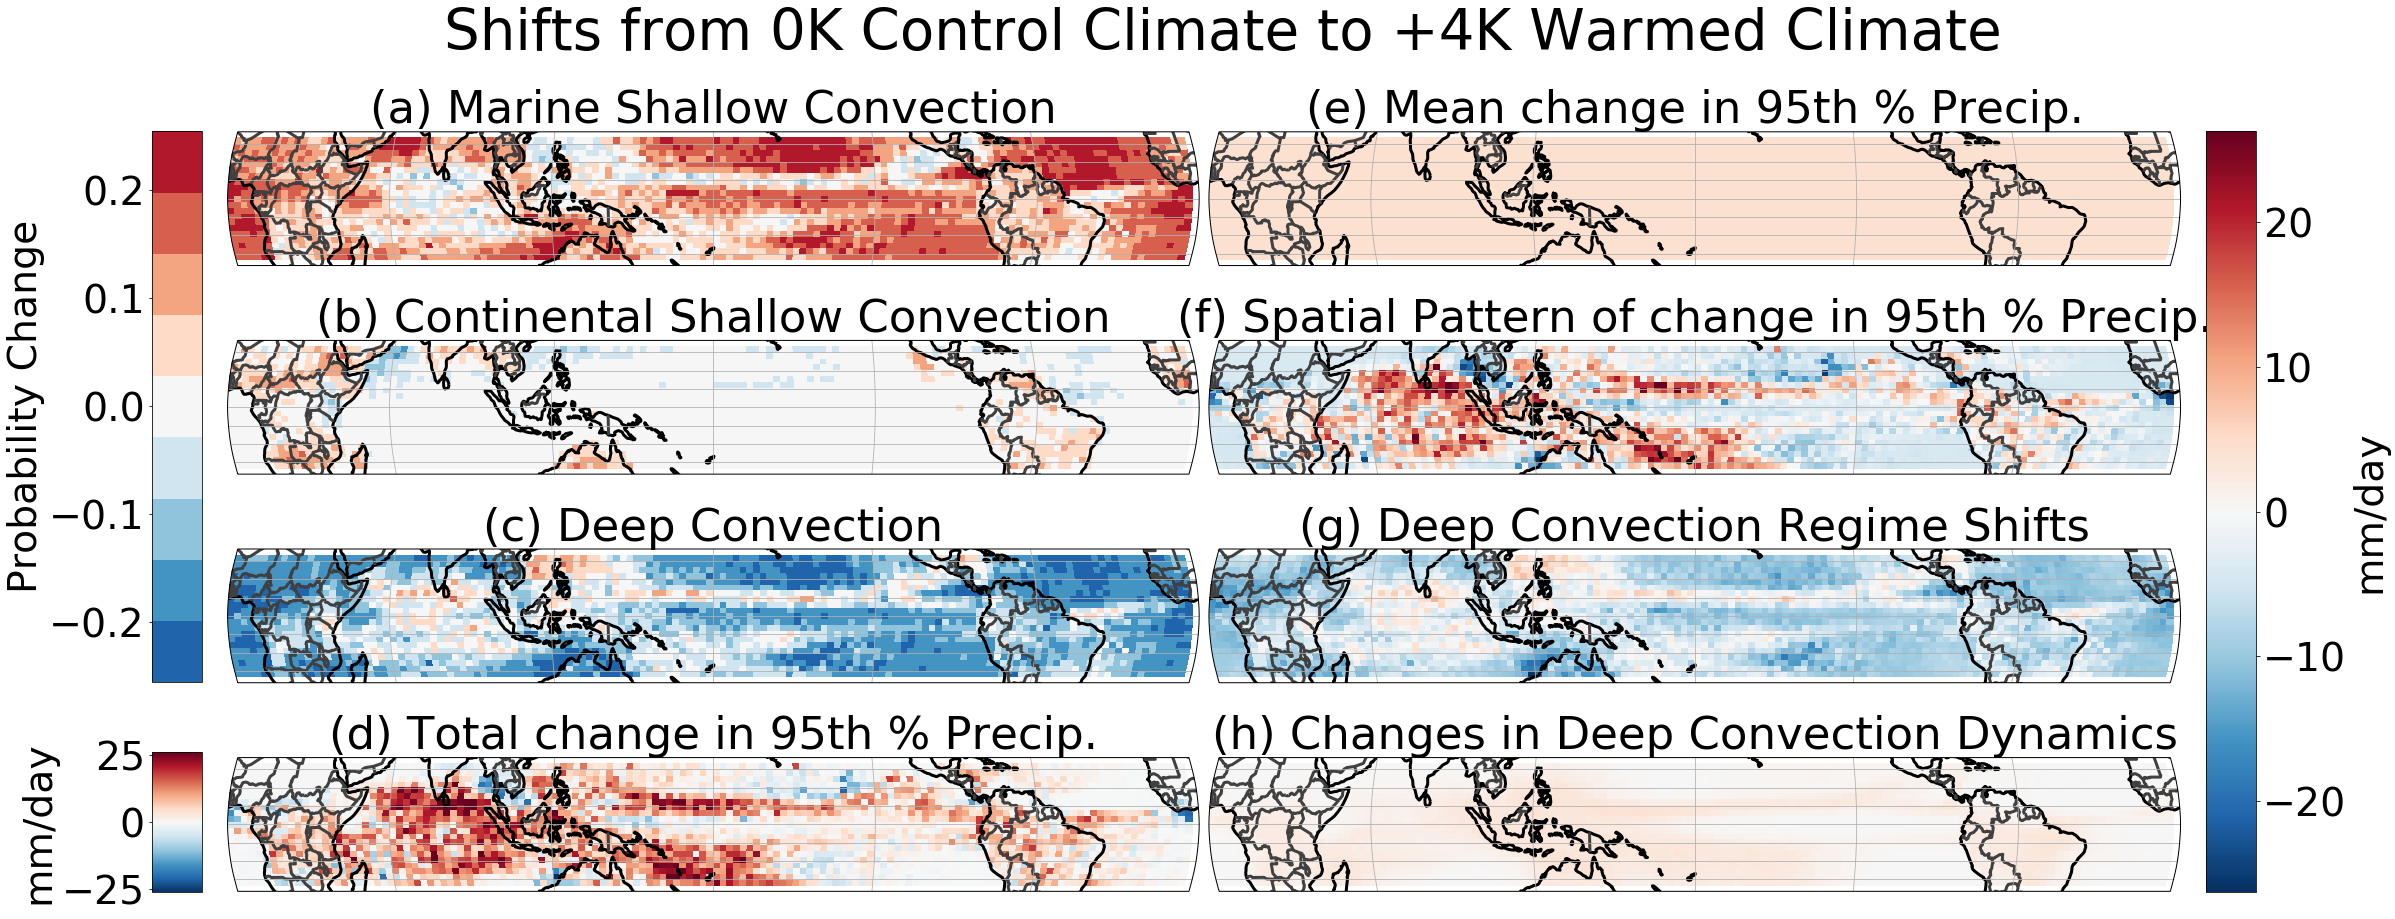

In [45]:
vmin = -1.0*np.max(np.abs(deep_convection_proportion))/1.5
vmax = np.max(np.abs(deep_convection_proportion))/1.5

cmap = ListedColormap(sns.color_palette("RdBu_r", n_colors = 9))

fig, ax = plt.subplots(4,2,figsize=(35,15),subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})

contour_plot = ax[0,0].pcolormesh(new_lons, new_lats, sc_convection_proportion, cmap=cmap, transform=ccrs.PlateCarree(), rasterized=True, vmin=vmin, vmax = vmax)
ax[0,0].coastlines(linewidth=3,edgecolor='0.25') 
ax[0,0].gridlines()
ax[0,0].add_feature(cfeature.BORDERS,linewidth=3,edgecolor='0.25')
ax[0,0].set_title("(a) Marine Shallow Convection", fontsize = fz*2)

contour_plot = ax[1,0].pcolormesh(new_lons, new_lats, csc_convection_proportion, cmap=cmap, transform=ccrs.PlateCarree(), rasterized=True, vmin=vmin, vmax = vmax)
ax[1,0].coastlines(linewidth=3,edgecolor='0.25')
ax[1,0].gridlines()
ax[1,0].add_feature(cfeature.BORDERS,linewidth=3,edgecolor='0.25')
ax[1,0].set_title("(b) Continental Shallow Convection", fontsize = fz*2)

contour_plot = ax[2,0].pcolormesh(new_lons, new_lats, deep_convection_proportion, cmap=cmap, transform=ccrs.PlateCarree(), rasterized=True, vmin=vmin, vmax = vmax)
ax[2,0].coastlines(linewidth=3,edgecolor='0.25')
ax[2,0].gridlines()
ax[2,0].add_feature(cfeature.BORDERS,linewidth=3,edgecolor='0.25')
ax[2,0].set_title("(c) Deep Convection", fontsize = fz*2)

cax_2 = fig.add_axes([0.095, 0.345, 0.02, 0.51])
cb_2 = fig.colorbar(contour_plot, cax=cax_2)
cb_2.set_label('Probability Change', fontsize=fz*1.75)
cb_2.ax.tick_params(labelsize=fz*1.75)
cax_2.yaxis.set_ticks_position('left')
cax_2.yaxis.set_label_position('left')

vmax = np.percentile(np.abs(P_95_4k - P_95_0k), 99)
vmin = -vmax
cmap = "RdBu_r"

contour_plot = ax[3,0].pcolormesh(new_lons, new_lats, P_95_4k - P_95_0k, cmap=cmap, transform=ccrs.PlateCarree(), rasterized=True, vmin=vmin, vmax = vmax)
ax[3,0].coastlines(linewidth=3,edgecolor='0.25') 
ax[3,0].gridlines()
ax[3,0].add_feature(cfeature.BORDERS,linewidth=3,edgecolor='0.25')
ax[3,0].set_title("(d) Total change in 95th % Precip.", fontsize = fz*2)

cax_2 = fig.add_axes([0.095, 0.15, 0.02, 0.13])
cb_2 = fig.colorbar(contour_plot, cax=cax_2)
cb_2.set_label('mm/day', fontsize=fz*1.75)
cb_2.ax.tick_params(labelsize=fz*1.75)
cax_2.yaxis.set_ticks_position('left')
cax_2.yaxis.set_label_position('left')

contour_plot = ax[0,1].pcolormesh(new_lons, new_lats, mean_changes, cmap=cmap, transform=ccrs.PlateCarree(), rasterized=True, vmin=vmin, vmax = vmax)
ax[0,1].coastlines(linewidth=3,edgecolor='0.25') 
ax[0,1].gridlines()
ax[0,1].add_feature(cfeature.BORDERS,linewidth=3,edgecolor='0.25')
ax[0,1].set_title("(e) Mean change in 95th % Precip.", fontsize = fz*2)

contour_plot = ax[1,1].pcolormesh(new_lons, new_lats, P_95_4k - P_95_0k - np.mean(P_95_4k - P_95_0k), cmap=cmap, transform=ccrs.PlateCarree(), rasterized=True, vmin=vmin, vmax = vmax)
ax[1,1].coastlines(linewidth=3,edgecolor='0.25') 
ax[1,1].gridlines()
ax[1,1].add_feature(cfeature.BORDERS,linewidth=3,edgecolor='0.25')
ax[1,1].set_title("(f) Spatial Pattern of change in 95th % Precip.", fontsize = fz*2)

cax_3 = fig.add_axes([0.91, 0.15, 0.02, 0.705])
cb_3 = fig.colorbar(contour_plot, cax=cax_3)
cb_3.set_label('mm/day', fontsize=fz*1.75)
cb_3.ax.tick_params(labelsize=fz*1.75)

contour_plot = ax[2,1].pcolormesh(new_lons, new_lats, deep_conv_regime_shift, cmap=cmap, transform=ccrs.PlateCarree(), rasterized=True, vmin=vmin, vmax = vmax)
ax[2,1].coastlines(linewidth=3,edgecolor='0.25') 
ax[2,1].gridlines()
ax[2,1].add_feature(cfeature.BORDERS,linewidth=3,edgecolor='0.25')
ax[2,1].set_title("(g) Deep Convection Regime Shifts", fontsize = fz*2)

contour_plot = ax[3,1].pcolormesh(new_lons, new_lats, changes_in_deep_conv_dynamics, cmap=cmap, transform=ccrs.PlateCarree(), rasterized=True, vmin=vmin, vmax = vmax)
ax[3,1].coastlines(linewidth=3,edgecolor='0.25') 
ax[3,1].gridlines()
ax[3,1].add_feature(cfeature.BORDERS,linewidth=3,edgecolor='0.25')
ax[3,1].set_title("(h) Changes in Deep Convection Dynamics", fontsize = fz*2)

plt.subplots_adjust(wspace=0.01, hspace=0.1)
plt.suptitle("Shifts from 0K Control Climate to +4K Warmed Climate", y = 0.97, x = 0.52, fontsize=fz*2.5)
plt.savefig("Figures/Figure_3.png", bbox_inches='tight',pad_inches = 0)
plt.savefig("Figures/Figure_3.pdf", bbox_inches='tight',pad_inches = 0)

# Additional Decomposition

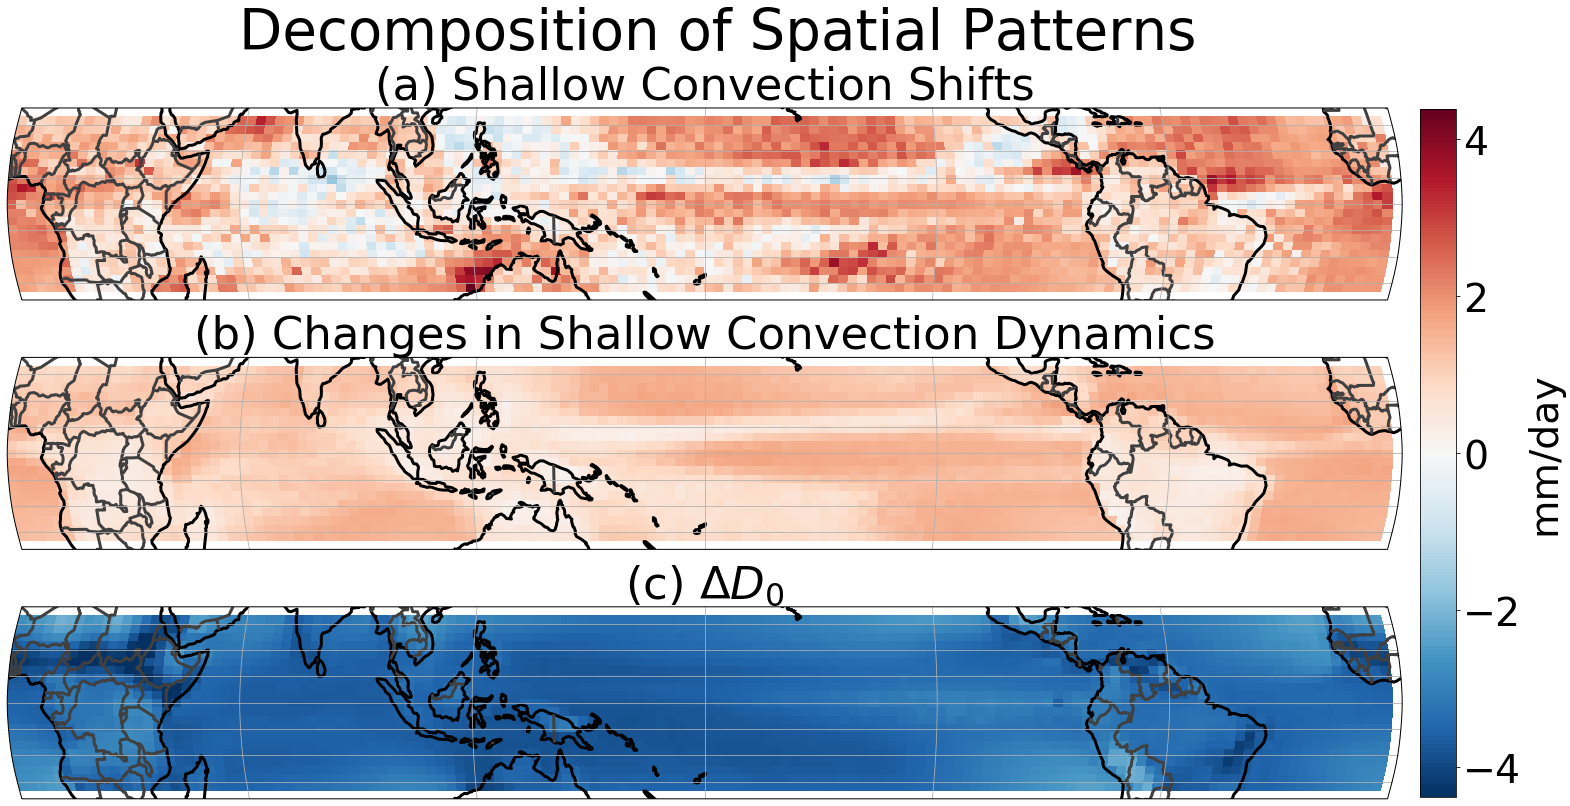

In [66]:
vmax = np.percentile(np.abs(P_95_4k - P_95_0k), 99)/6
vmin = -vmax
cmap = "RdBu_r"

fig, ax = plt.subplots(3,1,figsize=(25,13),subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})

contour_plot = ax[0].pcolormesh(new_lons, new_lats, shallow_conv_regime_shift, cmap=cmap, transform=ccrs.PlateCarree(), rasterized=True, vmin=vmin, vmax = vmax)
ax[0].coastlines(linewidth=3,edgecolor='0.25') 
ax[0].gridlines()
ax[0].add_feature(cfeature.BORDERS,linewidth=3,edgecolor='0.25')
ax[0].set_title("(a) Shallow Convection Shifts", fontsize = fz*2)

contour_plot = ax[1].pcolormesh(new_lons, new_lats, changes_in_shallow_conv_dynamics, cmap=cmap, transform=ccrs.PlateCarree(), rasterized=True, vmin=vmin, vmax = vmax)
ax[1].coastlines(linewidth=3,edgecolor='0.25')
ax[1].gridlines()
ax[1].add_feature(cfeature.BORDERS,linewidth=3,edgecolor='0.25')
ax[1].set_title("(b) Changes in Shallow Convection Dynamics", fontsize = fz*2)

contour_plot = ax[2].pcolormesh(new_lons, new_lats, Do, cmap=cmap, transform=ccrs.PlateCarree(), rasterized=True, vmin=vmin, vmax = vmax)
ax[2].coastlines(linewidth=3,edgecolor='0.25')
ax[2].gridlines()
ax[2].add_feature(cfeature.BORDERS,linewidth=3,edgecolor='0.25')
ax[2].set_title("(c) "+r"$ \Delta D_0$", fontsize = fz*2)

cax_3 = fig.add_axes([0.91, 0.135, 0.02, 0.735])
cb_3 = fig.colorbar(contour_plot, cax=cax_3)
cb_3.set_label('mm/day', fontsize=fz*1.75)
cb_3.ax.tick_params(labelsize=fz*1.75)

#plt.subplots_adjust(wspace=0.01, hspace=0.1)
plt.suptitle("Decomposition of Spatial Patterns", y = 0.98, x = 0.52, fontsize=fz*2.5)
plt.savefig("Figures/Equation_1_Decomposition.png", bbox_inches='tight',pad_inches = 0)
plt.savefig("Figures/Equation_1_Decomposition.pdf", bbox_inches='tight',pad_inches = 0)